In [82]:
import kagglehub
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sentence_transformers import SentenceTransformer
import faiss
import umap
import hdbscan
import warnings


In [83]:
# Download latest version
path = kagglehub.dataset_download("nelgiriyewithana/most-streamed-spotify-songs-2024")
print("Dataset downloaded to:", path)

Dataset downloaded to: /Users/klaudia/.cache/kagglehub/datasets/nelgiriyewithana/most-streamed-spotify-songs-2024/versions/1


In [ ]:
csv_path = os.path.join(path, file)
print("Found CSV:", csv_path)

In [ ]:
df = pd.read_csv(csv_path, encoding='latin1')

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Track                       4600 non-null   object        
 1   Album Name                  4600 non-null   object        
 2   Artist                      4595 non-null   object        
 3   Release Date                4600 non-null   datetime64[ns]
 4   ISRC                        4600 non-null   object        
 5   All Time Rank               4600 non-null   object        
 6   Track Score                 4600 non-null   float64       
 7   Spotify Streams             4487 non-null   object        
 8   Spotify Playlist Count      4600 non-null   object        
 9   Spotify Playlist Reach      4528 non-null   object        
 10  Spotify Popularity          3796 non-null   float64       
 11  YouTube Views               4292 non-null   object      

In [ ]:
df.describe()

In [85]:
df.head(5)

,Track,Album Name,Artist,Release Date,ISRC,All Time Rank,Track Score,Spotify Streams,Spotify Playlist Count,Spotify Playlist Reach,...,Deezer Playlist Reach,Amazon Playlist Count,Pandora Streams,Pandora Track Stations,Soundcloud Streams,Shazam Counts,Explicit Track,Year,Release Month,Release Year
0,MILLION DOLLAR BABY,Million Dollar Baby - Single,Tommy Richman,2024-04-26,QM24S2402528,1,725.4,"390,470,936",30716,"196,631,588",...,"17,598,718",114.0,"18,004,655","22,931","4,818,457","2,669,262",0,2024,4,2024
1,Not Like Us,Not Like Us,Kendrick Lamar,2024-05-04,USUG12400910,2,545.9,"323,703,884",28113,"174,597,137",...,"10,422,430",111.0,"7,780,028","28,444","6,623,075","1,118,279",1,2024,5,2024
2,i like the way you kiss me,I like the way you kiss me,Artemas,2024-03-19,QZJ842400387,3,538.4,"601,309,283",54331,"211,607,669",...,"36,321,847",172.0,"5,022,621","5,639","7,208,651","5,285,340",0,2024,3,2024
3,Flowers,Flowers - Single,Miley Cyrus,2023-01-12,USSM12209777,4,444.9,"2,031,280,633",269802,"136,569,078",...,"24,684,248",210.0,"190,260,277","203,384",NaN,"11,822,942",0,2023,1,2023
4,Houdini,Houdini,Eminem,2024-05-31,USUG12403398,5,423.3,"107,034,922",7223,"151,469,874",...,"17,660,624",105.0,"4,493,884","7,006","207,179","457,017",1,2024,5,2024


## Cleaning data

#### Missing values

In [43]:
df_missing = pd.DataFrame(df.isnull().sum()).reset_index().rename(columns={'index': 'Track', 0: 'Missing Values'})
df_missing.drop(index=df.index[0], axis=0, inplace=True)
df_missing[df_missing['Missing Values']>0].sort_values(by='Missing Values', ascending=False)

,Track,Missing Values
27,TIDAL Popularity,4600
25,Soundcloud Streams,3333
19,SiriusXM Spins,2123
24,Pandora Track Stations,1268
13,TikTok Posts,1173
23,Pandora Streams,1106
22,Amazon Playlist Count,1055
16,YouTube Playlist Reach,1009
15,TikTok Views,981
14,TikTok Likes,980


In [44]:
df.drop('TIDAL Popularity', axis=1, inplace=True)

In [45]:
df['Spotify Playlist Count'] = df['Spotify Playlist Count'].fillna(0)
df['Spotify Playlist Count'].isnull().sum()

np.int64(0)

#### Data types

In [46]:
df['Spotify Playlist Count'] = df['Spotify Playlist Count'].fillna(0)
df['Spotify Playlist Count'].isnull().sum()

np.int64(0)

In [47]:
df['Spotify Playlist Count'] = df['Spotify Playlist Count'].apply(lambda x: str(x).replace(',', ''))
df['Spotify Playlist Count']

0        30716
1        28113
2        54331
3       269802
4         7223
         ...  
4595     65770
4596      4602
4597     72066
4598     14037
4599     32138
Name: Spotify Playlist Count, Length: 4600, dtype: object

#### Duplicates

In [51]:
df_duplicates = pd.DataFrame(df.duplicated()).rename(columns={0: 'duplicate'})
df_duplicates[df_duplicates['duplicate'] == True]

,duplicate
2450,True
3450,True


In [55]:
df.iloc[2450]

Track                            Tennessee Orange
Album Name                       Tennessee Orange
Artist                              Megan Moroney
Release Date                  2022-09-02 00:00:00
ISRC                                 TCAGJ2289254
All Time Rank                               2,424
Track Score                                  28.9
Spotify Streams                       227,893,586
Spotify Playlist Count                      28139
Spotify Playlist Reach                 12,480,714
Spotify Popularity                           73.0
YouTube Views                          30,913,276
YouTube Likes                             159,791
TikTok Posts                               77,661
TikTok Likes                           13,324,305
TikTok Views                          117,505,652
YouTube Playlist Reach                238,206,228
Apple Music Playlist Count                   33.0
AirPlay Spins                             129,172
SiriusXM Spins                                 34


In [56]:
df.iloc[3450]

Track                                      Dembow
Album Name                                 Dembow
Artist                                Danny Ocean
Release Date                  2017-12-08 00:00:00
ISRC                                 USWL11700269
All Time Rank                               3,441
Track Score                                  23.3
Spotify Streams                       579,189,526
Spotify Playlist Count                      60397
Spotify Playlist Reach                 11,805,084
Spotify Popularity                           65.0
YouTube Views                         828,853,696
YouTube Likes                           3,086,157
TikTok Posts                               84,450
TikTok Likes                           21,202,350
TikTok Views                          158,504,854
YouTube Playlist Reach                199,705,679
Apple Music Playlist Count                   34.0
AirPlay Spins                               5,406
SiriusXM Spins                                  9


In [57]:
df.iloc[2449: 2451]

,Track,Album Name,Artist,Release Date,ISRC,All Time Rank,Track Score,Spotify Streams,Spotify Playlist Count,Spotify Playlist Reach,...,SiriusXM Spins,Deezer Playlist Count,Deezer Playlist Reach,Amazon Playlist Count,Pandora Streams,Pandora Track Stations,Soundcloud Streams,Shazam Counts,Explicit Track,Year
2449,Tennessee Orange,Tennessee Orange,Megan Moroney,2022-09-02,TCAGJ2289254,"2,424",28.9,"227,893,586",28139,"12,480,714",...,34,5.0,"1,370",49.0,"56,972,562","26,968","1,336,043","708,143",0,2022
2450,Tennessee Orange,Tennessee Orange,Megan Moroney,2022-09-02,TCAGJ2289254,"2,424",28.9,"227,893,586",28139,"12,480,714",...,34,5.0,"1,370",49.0,"56,972,562","26,968","1,336,043","708,143",0,2022


#### Identify outliers

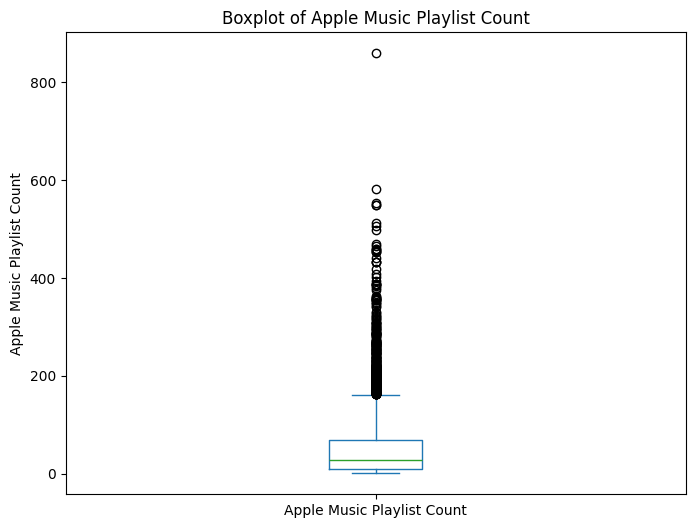

In [58]:
plt.figure(figsize=(8, 6))
df['Apple Music Playlist Count'].plot(kind='box')
plt.title('Boxplot of Apple Music Playlist Count')
plt.ylabel('Apple Music Playlist Count')
plt.show()

#### Data format

In [60]:
df['Release Date'] = pd.to_datetime(df['Release Date'])
df['Release Month'] = df['Release Date'].dt.month
df['Release Date']

0      2024-04-26
1      2024-05-04
2      2024-03-19
3      2023-01-12
4      2024-05-31
          ...    
4595   2017-09-05
4596   2018-07-27
4597   2020-02-28
4598   2016-11-08
4599   2017-04-11
Name: Release Date, Length: 4600, dtype: datetime64[ns]

In [61]:
df['Release Year'] = df['Release Date'].dt.year
df['Release Year']

0       2024
1       2024
2       2024
3       2023
4       2024
        ... 
4595    2017
4596    2018
4597    2020
4598    2016
4599    2017
Name: Release Year, Length: 4600, dtype: int32

### Analysis

In [63]:
songs_per_years = df['Release Year'].value_counts().sort_index()
songs_per_years

Release Year
1987       1
1991       1
1994       1
1998       1
1999       1
2000       2
2001       1
2002       5
2003       3
2004       5
2005       5
2006       3
2007       5
2008      11
2009      15
2010      27
2011      51
2012      47
2013      55
2014      70
2015      96
2016     123
2017     213
2018     249
2019     296
2020     360
2021     408
2022     694
2023    1158
2024     693
Name: count, dtype: int64

In [68]:
single_years = songs_per_years[songs_per_years >= 30]
print(single_years)

Release Year
2011      51
2012      47
2013      55
2014      70
2015      96
2016     123
2017     213
2018     249
2019     296
2020     360
2021     408
2022     694
2023    1158
2024     693
Name: count, dtype: int64


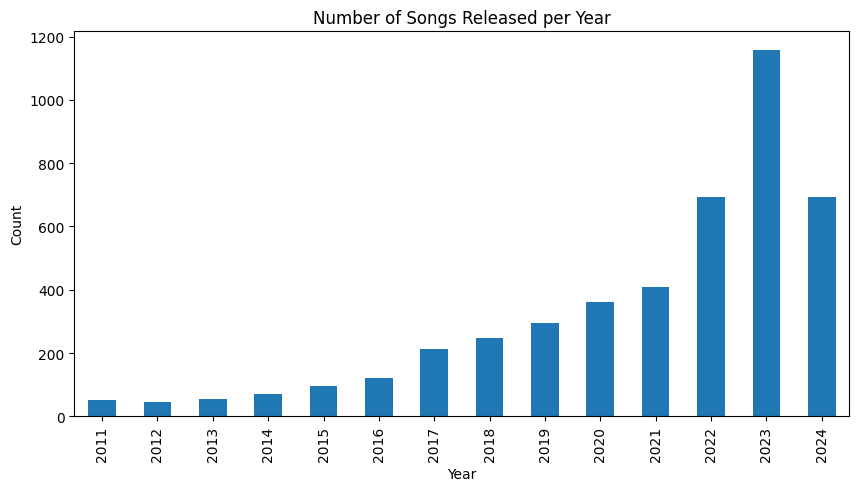

In [69]:
single_years.sort_index().plot(kind='bar', figsize=(10,5))
plt.title("Number of Songs Released per Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()

In [72]:
value_counts = df['Artist'].value_counts()
value_counts

Artist
Drake                       63
Taylor Swift                63
Bad Bunny                   60
KAROL G                     32
The Weeknd                  31
                            ..
Carrier                      1
Javed Ali                    1
The King Khan & BBQ Show     1
Marca MP                     1
BUSHIDO ZHO                  1
Name: count, Length: 1999, dtype: int64

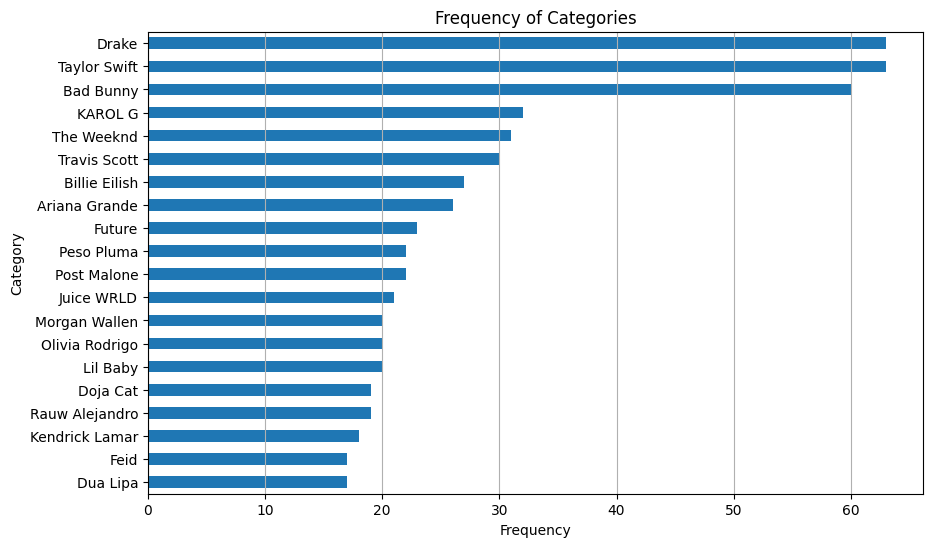

In [74]:
plt.figure(figsize=(10, 6))
value_counts.head(20).plot(kind='barh')

plt.xlabel('Frequency')
plt.ylabel('Category')
plt.title('Frequency of Categories')
plt.gca().invert_yaxis()  # The highest frequency on top
plt.grid(axis='x')
plt.show()

In [75]:
numerical_cols = [col for col in df.columns if df[col].dtype not in ['object', 'category', 'datetime64[ns]']]
numerical_cols

['Track Score',
 'Spotify Popularity',
 'Apple Music Playlist Count',
 'Deezer Playlist Count',
 'Amazon Playlist Count',
 'Explicit Track',
 'Year',
 'Release Month',
 'Release Year']

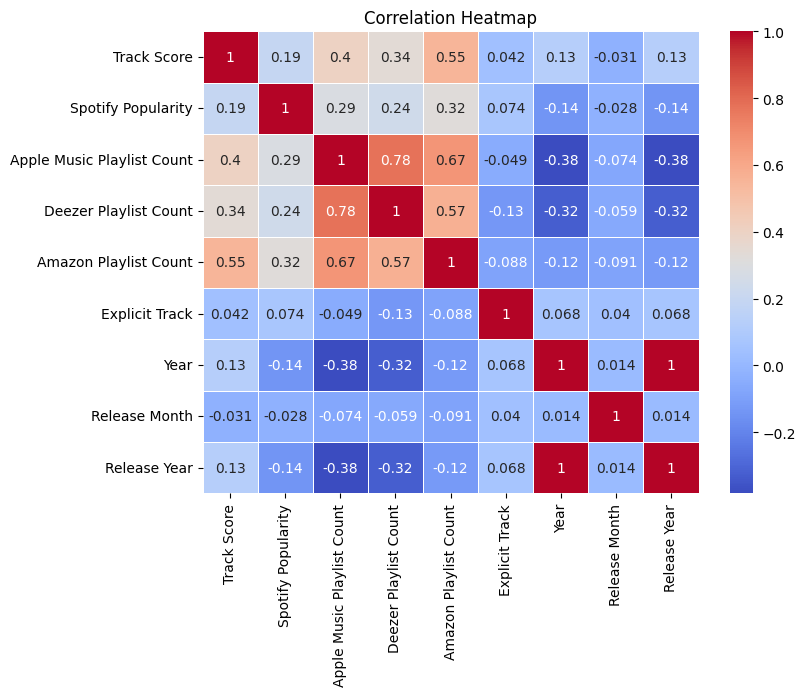

In [79]:
correlation_matrix = df[numerical_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

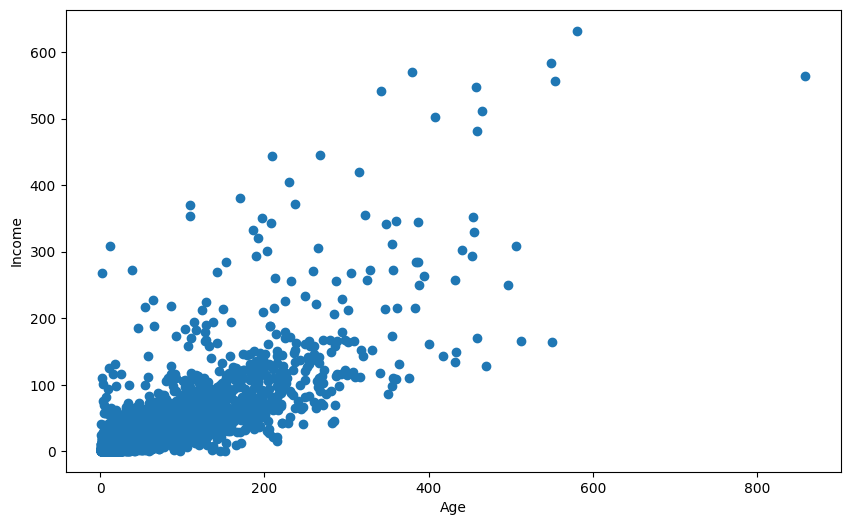

In [80]:
plt.figure(figsize=(10, 6))
plt.scatter(df['Apple Music Playlist Count'], df['Deezer Playlist Count'])
plt.xlabel('Age')
plt.ylabel('Income')
plt.show()

In [81]:
!pip install faiss-cpu umap-learn hdbscan sentence-transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 45.3 MB/s  0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 12.9 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 93.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 31.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 74.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 74.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 71.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 86.3 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 89.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.3/30.3 MB 95.7 MB/s  0:00:00m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 MB 90.8 MB/s  0:00:0